In [15]:
import os
import numpy as np
from os import walk
from random import shuffle

def load_level_files(path):
    files = []
    for (dirpath, dirnames, filenames) in walk(path):
        files.extend(filenames)
        break
    for f in range(len(files)):
        files[f] = path + files[f]
    return files

def file_len(file):
    return sum(1 for line in file)

def parse_level_file(file_content):
    rows = file_content.split("\n")[:-1]
    height = len(rows)
    width = len(rows[0])
    level = np.zeros((len(tileset), height, width))
    y = 0
    for row in rows:
        x = 0
        for tile in row:
            if tile != '.':
                for t in range(len(tileset)):
                    if tileset[t] == tile:
                        level[t][y][x] = 1
                        break
            x += 1
        y += 1
    return level

def get_level_content(files):
    levels = []
    for f in range(len(files)):
        filename = files[f]
        if filename[-4:] != '.txt':
            continue
        #print(filename)
        file = open(filename, 'r')
        content = file.read()
        levels.append(content)
    return levels

def parse_level_files(files):
    levels = []
    for f in range(len(files)):
        filename = files[f]
        if filename[-4:] != '.txt':
            continue
        #print(filename)
        file = open(filename, 'r')
        content = file.read()
        #print(content)
        level = parse_level_file(content)
        #print(level)
        levels.append(level)
        #break
    return levels

#won_files = load_level_files("./levels/" + game + "/won/")
#lost_files = load_level_files("./levels" + game + "/lost/")
#human_won_files = load_level_files("./levels" + game + "/human_won/")
#human_files = load_level_files("./levels" + game + "/human/")
#human_lost_files = load_level_files("./levels" + game + "/human_lost/")
#won_levels = parse_level_files(won_files)
#lost_levels = parse_level_files(lost_files)
#human_levels = parse_level_files(human_files)
#human_won_levels = parse_level_files(human_won_files)
#human_lost_levels = parse_level_files(human_lost_files)
#all_levels = won_levels + lost_levels + human_levels
#all_labels = ["Won" for _ in won_levels] + ["Lost" for _ in lost_levels] + ["Human" for _ in human_levels]
#all_colors = [green for _ in won_levels] + [red for _ in lost_levels] + [blue for _ in human_levels]

In [16]:
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

games = ["solarfox", "zelda", "frogs", "boulderdash"]

green = "#55cc55"
red = "#cc5555"
blue = "#5555cc"

processed_pca = {}
processed_tsne = {}
levels = {}

for game in games:
    print("processing " + game)
    if game == "zelda":
        tileset = ['w', 'A', 'g', '+', '1', '2', '3']
    elif game == "frogs":
        tileset = ['w', 'A', 'g', '+', 'x', '0', '=', '-', '4', '3', '2', '1', 'l']
    elif game == "solarfox":
        tileset = ['w', 'A', 'p', '+', 'b', '1', '2']
    elif game == "boulderdash":
        tileset = ['w', 'x', 'o', 'c', '-', 'b', 'e']

    gen_files = load_level_files("./data/test-levels/" + game + "/10/")
    human_files = load_level_files("./levels/" + game + "/human/")
    gen_levels = parse_level_files(gen_files)
    human_levels = parse_level_files(human_files)
    all_labels = ["PCG" for _ in gen_levels] + ["Human" for _ in human_levels]
    all_labels = ["PCG" for _ in gen_levels] + ["Human" for _ in human_levels]
    all_colors = [red for _ in gen_levels] + [blue for _ in human_levels]
    all_levels = gen_levels + human_levels
    print("{} levels loaded".format(len(all_levels)))
    arr = np.array(all_levels)
    print(arr.shape)
    components = np.array(all_levels).reshape((arr.shape[0], arr.shape[1] * arr.shape[2] * arr.shape[3]))
    pca = PCA(n_components=2)
    transformed_pca = pca.fit_transform(components)
    processed_pca[game] = transformed_pca
    print("PCA computed")
    transformed_tsne = TSNE(n_components=2).fit_transform(components)
    processed_tsne[game] = transformed_tsne
    print("t-SNE computed")
    levels[game] = get_level_content(gen_files + human_files)
    print("File content loaded")

processing solarfox
30 levels loaded
(30, 7, 11, 10)
PCA computed
t-SNE computed
File content loaded
processing zelda
30 levels loaded
(30, 7, 9, 13)
PCA computed
t-SNE computed
File content loaded
processing frogs
30 levels loaded
(30, 13, 11, 28)
PCA computed
t-SNE computed
File content loaded
processing boulderdash
30 levels loaded
(30, 7, 13, 26)
PCA computed
t-SNE computed
File content loaded


In [17]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
from sklearn.cluster import DBSCAN
from sklearn import metrics

def closest_point(point, points):
    points = np.asarray(points)
    dist_2 = np.sum((points - point)**2, axis=1)
    return points[np.argmin(dist_2)]

def plot(data, pca=False, eps=0.3, min_samples=10):
    fig, plot = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.prism()
    
    #plot.scatter(data[...,0][:-5], data[...,1][:-5], c=all_colors[:-5])
    #s = [100 for n in range(5)]
    #plot.scatter(data[...,0][-5:], data[...,1][-5:], c=all_colors[-5:], marker='s', s=s)

    # Clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('Estimated number of clusters: %d' % n_clusters_)
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
        
        # Find centroids
        if len(xy) > 0:
            center = (sum(xy[:, 0]) / len(xy), sum(xy[:, 1]) / len(xy))
            centroid = closest_point(center, xy)
            centroid_idx = -1
            assert centroid in data
            for i in range(len(data)):
                if np.array_equal(data[i], centroid):
                    centroid_idx = i
                    break
            assert centroid_idx >= 0
            
            print("Centroid of cluster {} with color {}".format(k, col))
            print(levels[game][centroid_idx])
            
            plt.plot(centroid[0], centroid[1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=12)
            
        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
        
        '''
        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
        '''
        
    plot.set_xticks(())
    plot.set_yticks(())
    custom_lines = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor=red, markersize=8), 
                    Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='white', markeredgecolor='black', markersize=8)]

    #for i in range(len(human_levels)):
    #    plot.annotate("Level {}".format(i), (data[len(gen_levels)+i][0], data[len(gen_levels)+i][1]))
    for i in range(len(human_levels)):
        bbox_props = dict(boxstyle="circle,pad=0.1", fc="white", ec="black", lw=2)
        t = plot.text(data[len(gen_levels)+i][0], data[len(gen_levels)+i][1], i, ha="center", va="center", rotation=0,
                    size=15,
                    bbox=bbox_props)

    #lines = ax.plot(data)
    title = "{} on {} levels".format("PCA" if pca else "t-SNE", game.title())
    plt.title(title)
    #plot.legend(custom_lines, ['PCG', 'Human'], loc=1)
    #plot.legend(['Won', 'Lost', 'Human'], loc=2)
    fig.savefig("levels/images/" + game + ("_pca" if pca else "_t-sne") + ".pdf", bbox_inches='tight')
    return fig

Plotting for solarfox
Estimated number of clusters: 0
Estimated number of clusters: 0
Plotting for zelda
Estimated number of clusters: 0
Estimated number of clusters: 0
Plotting for frogs
Estimated number of clusters: 0
Estimated number of clusters: 0
Plotting for boulderdash
Estimated number of clusters: 0
Estimated number of clusters: 0


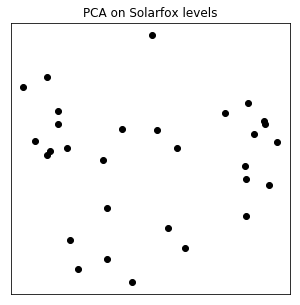

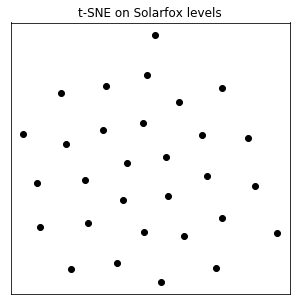

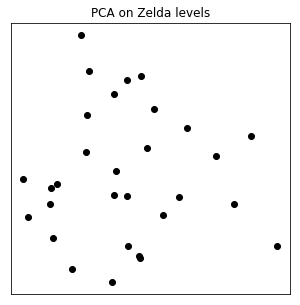

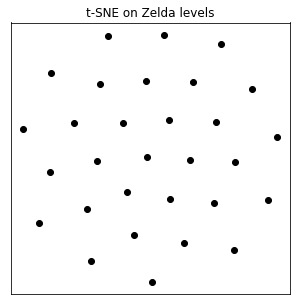

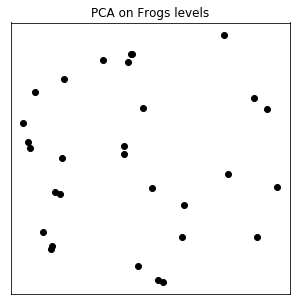

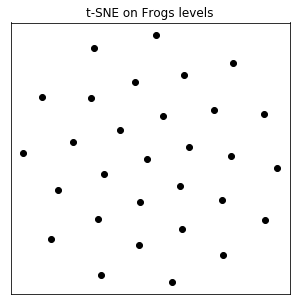

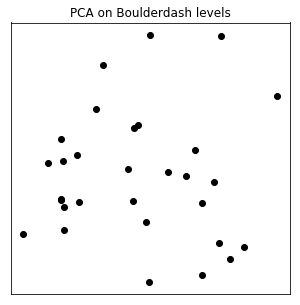

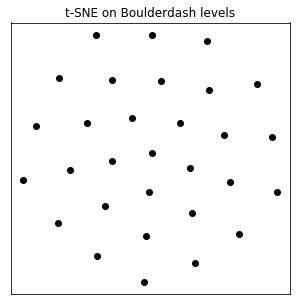

In [18]:
for game in games:
    print("Plotting for " + game)
    plot(processed_pca[game], pca=True, eps=0.5, min_samples=10)
    plot(processed_tsne[game], pca=False, eps=5, min_samples=25)